# Parameter correlation and error distributions


## Confidence ellipse function

In [31]:
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

## Correlation of parameter
This script illustrates correlation of LANTMET and MESAN data points. Fetch data for a selected period over a set of years. For example, the user may want to investigate the correlation of temperature during June and August for the years 2017-2019. Then the user specifies start_month = 6 and end_month = 8, start_year = 2017 and end_year = 2019. Together with a scatter plot the user gets pearson's correlation coefficient along with a confidence ellipse which encloses datapoints within four standard deviations.

Loading data...
Checking for missing values...
Found NaN value at 2019-01-07T23:00:00Z. Removing from both datasets.


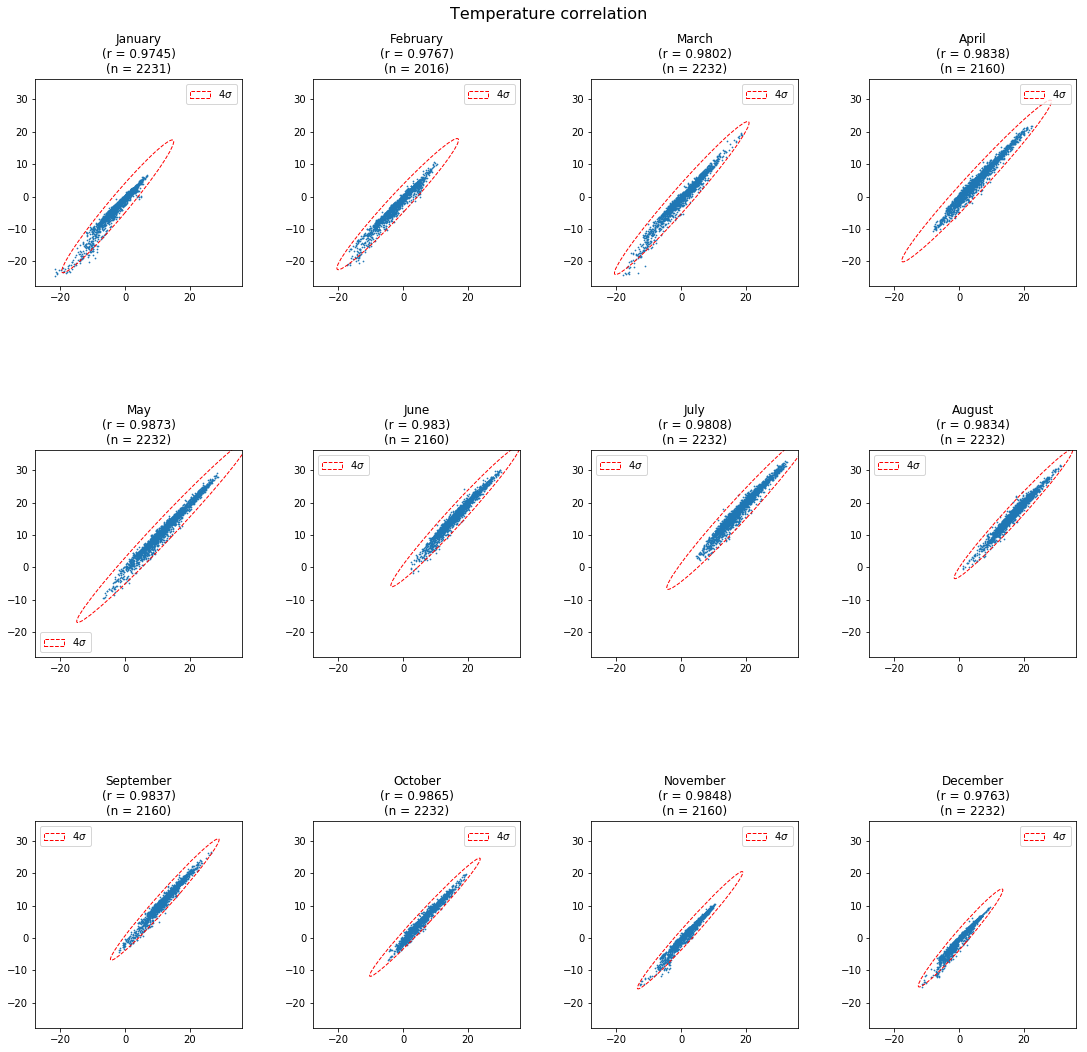

In [32]:
from METCOMP_utils import *
import matplotlib.pyplot as plt
import datetime
from scipy.stats import pearsonr
import numpy as np
import pandas as pd


# Select arbitrary interval/only fetch data for summer months.
station = '40010'
param = 'TM'
scale = 1.1

start_year = 2017
end_year = 2019
start_month = 6
end_month = 8
start_day = 1
end_day = 31

df_LANTMET = pd.DataFrame()
df_MESAN = pd.DataFrame()
current_year = start_year

# Load data.
print('Loading data...')
for i in range(0, end_year - start_year + 1):
    start_date = datetime.date(current_year, start_month, start_day)
    end_date = datetime.date(current_year, end_month, end_day)
    df_LANTMET = df_LANTMET.append(get_LANTMET(station, start_date, end_date), ignore_index=True)
    df_MESAN = df_MESAN.append(read_CSV(station, 'MESAN', start_date, end_date))
    current_year = current_year + 1

# Translation dictionary from LANTMET designations to MESAN designations.
param_dict = {'TM': 't_sfc', 'RR': 'prec1h_sfc', 'UM': 'r_sfc', 'FM2': 'ws_sfc'}

# Unit conversion if needed.
if param == 'TM':
    df_MESAN[param_dict[param]] = df_MESAN[param_dict[param]] - 273.15
elif param == 'UM':
    df_MESAN[param_dict[param]] = df_MESAN[param_dict[param]]*100

# Check for missing values. Remove from both datasets.
print('Checking for missing values...')
bad_rows = {}
bad_MESAN = df_MESAN[df_MESAN[param_dict[param]].isnull()]
bad_LANTMET = df_LANTMET[df_LANTMET[param].isnull()]
# Find rows
for index, df_row in bad_MESAN.iterrows():
    bad_rows[df_row['Timestamp']] = None
for index, df_row in bad_LANTMET.iterrows():
    bad_rows[df_row['Timestamp']] = None
# Remove rows.
for bad_row in bad_rows:
    print('Found NaN value at ' + bad_row + '. Removing from both datasets.', end='\n')
    df_MESAN = df_MESAN[~df_MESAN['Timestamp'].str.contains(bad_row)]
    df_LANTMET = df_LANTMET[~df_LANTMET['Timestamp'].str.contains(bad_row)]

# Construct combined dataframe.
timestamps = df_MESAN['Timestamp'].to_numpy()
df_COMB = pd.DataFrame.from_dict({'Timestamp': timestamps, 'MESAN': df_MESAN[param_dict[param]].to_numpy(), 'LANTMET': df_LANTMET[param].to_numpy()})

# Set equal limits for axis.
limits = [max(df_COMB['MESAN']), min(df_COMB['MESAN']), max(df_COMB['LANTMET']), min(df_COMB['LANTMET'])]
limits = [min(limits) - (scale-1)*max(limits), max(limits)*scale]

# Figure settings.
rows = 3
cols = 4

# Automatically choose figure title.
fig_title = 'Unknown parameter correlation'
if param == 'TM':
    fig_title = 'Temperature correlation'
elif param == 'UM':
    fig_title = 'Humidity correlation'
elif param == 'RR':
    fig_title = 'Precipitation correlation'
elif param == 'FM2':
    fig_title = 'Wind speed correlation'

# Setup figure and loop over each subplot.
fig, axs = plt.subplots(rows, cols, figsize=(16, 16))
fig.suptitle(fig_title, fontsize=16)
fig.tight_layout(pad=4.0)

month = 1
for row in range(0, rows):
    for col in range(0, cols):
        
        # Get month string. Pad with '0' ahead if single integer.
        month_str = ''
        if month < 10:
            month_str = '0' + str(month)
        else:
            month_str = str(month)
        
        # Splice a subset corresponding to current month.
        df_splice = df_COMB[df_COMB['Timestamp'].str.contains('-' + month_str + '-')]
        
        # Get month name.
        tmp_date = datetime.datetime.strptime('2020-' + month_str + '-01', '%Y-%m-%d').date()
        month_name = tmp_date.strftime('%B')
        
        # Get pearson correlation coefficient.
        n = df_splice.shape[0]
        if n > 2:
            r = round(pearsonr(df_splice['MESAN'].to_numpy(), df_splice['LANTMET'].to_numpy())[0], 4)
        else:
            r = 0
        
        # Scatter datapoints and get confidence ellipse.
        axs[row, col].scatter(df_splice['MESAN'].to_numpy(), df_splice['LANTMET'].to_numpy(), s=0.5)
        if n > 2:
            confidence_ellipse(df_splice['MESAN'].to_numpy(), df_splice['LANTMET'].to_numpy(), axs[row, col], n_std=4, label=r'$4\sigma$', edgecolor=(1, 0.0, 0), linestyle = '--')
            axs[row, col].legend()
        
        # Set limits and aspects.
        axs[row, col].set_xlim(limits)
        axs[row, col].set_ylim(limits)
        x0,x1 = axs[row, col].get_xlim()
        y0,y1 = axs[row, col].get_ylim()
        axs[row, col].set_aspect(abs(x1-x0)/abs(y1-y0))
        
        # Set subplot title to month name and include pearson correlation coefficient.
        axs[row, col].title.set_text(month_name + '\n(r = ' + str(r) + ')\n(n = ' + str(n) + ')' )
        
        month = month + 1

## Error distribution histogram
This script illustrates error distribution between LANTMET and MESAN data points. Fetch data for a selected period over a set of years. For example, the user may want to investigate the error distribution of temperature during June and August for the years 2017-2019. Then the user specifies start_month = 6 and end_month = 8, start_year = 2017 and end_year = 2019.

Loading data...
Checking for missing values...
Found NaN value at 2019-01-07T23:00:00Z. Removing from both datasets.


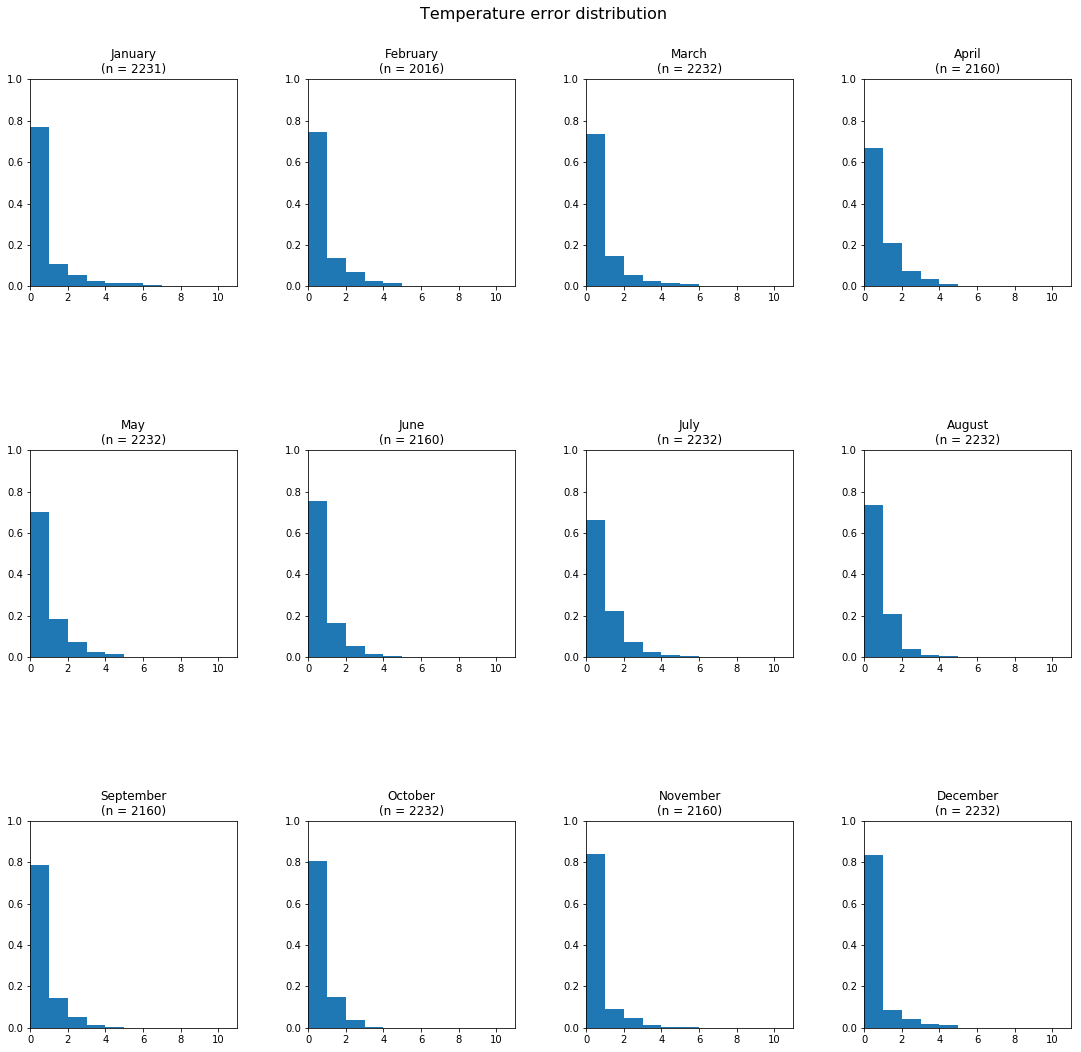

In [33]:
from METCOMP_utils import *
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd


# Select arbitrary interval/only fetch data for summer months.
station = '40010'
param = 'TM'
scale = 1.1
start_year = 2017
end_year = 2019
start_month = 6
end_month = 8
start_day = 1
end_day = 31
df_LANTMET = pd.DataFrame()
df_MESAN = pd.DataFrame()
current_year = start_year

# Load data.
print('Loading data...')
for i in range(0, end_year - start_year + 1):
    start_date = datetime.date(current_year, start_month, start_day)
    end_date = datetime.date(current_year, end_month, end_day)
    df_LANTMET = df_LANTMET.append(get_LANTMET(station, start_date, end_date), ignore_index=True)
    df_MESAN = df_MESAN.append(read_CSV(station, 'MESAN', start_date, end_date))
    current_year = current_year + 1

# Translation dictionary from LANTMET designations to MESAN designations.
param_dict = {'TM': 't_sfc', 'RR': 'prec1h_sfc', 'UM': 'r_sfc', 'FM2': 'ws_sfc'}

# Unit conversion if needed.
if param == 'TM':
    df_MESAN[param_dict[param]] = df_MESAN[param_dict[param]] - 273.15
elif param == 'UM':
    df_MESAN[param_dict[param]] = df_MESAN[param_dict[param]]*100

# Check for missing values. Remove from both datasets.
print('Checking for missing values...')
bad_rows = {}
bad_MESAN = df_MESAN[df_MESAN[param_dict[param]].isnull()]
bad_LANTMET = df_LANTMET[df_LANTMET[param].isnull()]
# Find rows
for index, df_row in bad_MESAN.iterrows():
    bad_rows[df_row['Timestamp']] = None
for index, df_row in bad_LANTMET.iterrows():
    bad_rows[df_row['Timestamp']] = None
# Remove rows.
for bad_row in bad_rows:
    print('Found NaN value at ' + bad_row + '. Removing from both datasets.', end='\n')
    df_MESAN = df_MESAN[~df_MESAN['Timestamp'].str.contains(bad_row)]
    df_LANTMET = df_LANTMET[~df_LANTMET['Timestamp'].str.contains(bad_row)]

# Construct error dataframe.
timestamps = df_MESAN['Timestamp'].to_numpy()
errors = abs(df_MESAN[param_dict[param]].to_numpy() - df_LANTMET[param].to_numpy())
df_ERROR = pd.DataFrame.from_dict({'Timestamp': timestamps, 'Error': errors})

# Set equal limits for axis.
limits = [0, max(df_ERROR['Error'])*scale]

# Figure settings.
rows = 3
cols = 4

# Automatically choose figure title.
fig_title = 'Unknown parameter error distribution'
if param == 'TM':
    fig_title = 'Temperature error distribution'
elif param == 'UM':
    fig_title = 'Humidity error distribution'
elif param == 'RR':
    fig_title = 'Precipitation error distribution'
elif param == 'FM2':
    fig_title = 'Wind speed error distribution'

fig, axs = plt.subplots(rows, cols, figsize=(16, 16))
fig.suptitle(fig_title, fontsize=16)
fig.tight_layout(pad=4.0)

# Histogram settings:
bin_width = 1.0
bins = np.arange(min(df_ERROR['Error']), max(df_ERROR['Error']) + bin_width, bin_width)

month = 1
for row in range(0, rows):
    for col in range(0, cols):
        
        # Get month string. Pad with '0' ahead if single integer.
        month_str = ''
        if month < 10:
            month_str = '0' + str(month)
        else:
            month_str = str(month)
        
        # Splice a subset corresponding to current month.
        splice_ERROR = df_ERROR[df_ERROR['Timestamp'].str.contains('-' + month_str + '-')]
        
        # Get month name.
        tmp_date = datetime.datetime.strptime('2020-' + month_str + '-01', '%Y-%m-%d').date()
        month_name = tmp_date.strftime('%B')   
        
        axs[row, col].hist(splice_ERROR['Error'], bins=bins, density=True)
        axs[row, col].set_xlim([0, max(bins)])
        axs[row, col].set_ylim([0, 1])
        
        x0,x1 = axs[row, col].get_xlim()
        y0,y1 = axs[row, col].get_ylim()
        axs[row, col].set_aspect(abs(x1-x0)/abs(y1-y0))
        
        axs[row, col].title.set_text(month_name + '\n(n = ' + str(splice_ERROR.shape[0]) + ')' )
        
        month = month + 1

## Error distribution boxplot
This script illustrates error distribution between LANTMET and MESAN data points. Fetch data for a selected period over a set of years. For example, the user may want to investigate the error distribution of temperature during June and August for the years 2017-2019. Then the user specifies start_month = 6 and end_month = 8, start_year = 2017 and end_year = 2019.

Loading data...
Checking for missing values...
Found NaN value at 2019-01-07T23:00:00Z. Removing from both datasets.


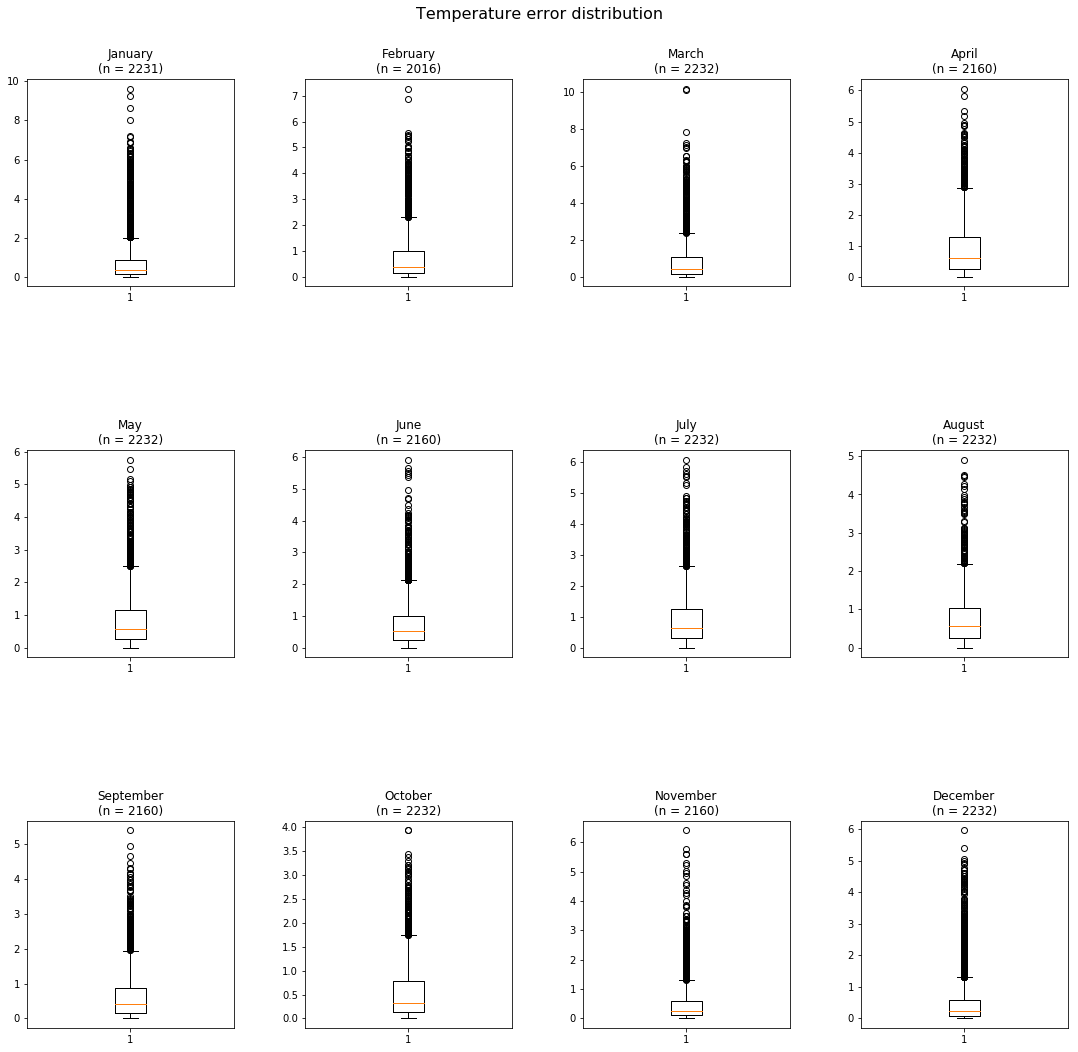

In [34]:
from METCOMP_utils import *
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd


# Select arbitrary interval/only fetch data for summer months.
station = '40010'
param = 'TM'
scale = 1.1
start_year = 2017
end_year = 2019
start_month = 6
end_month = 8
start_day = 1
end_day = 31
df_LANTMET = pd.DataFrame()
df_MESAN = pd.DataFrame()
current_year = start_year

# Load data.
print('Loading data...')
for i in range(0, end_year - start_year + 1):
    start_date = datetime.date(current_year, start_month, start_day)
    end_date = datetime.date(current_year, end_month, end_day)
    df_LANTMET = df_LANTMET.append(get_LANTMET(station, start_date, end_date), ignore_index=True)
    df_MESAN = df_MESAN.append(read_CSV(station, 'MESAN', start_date, end_date))
    current_year = current_year + 1

# Translation dictionary from LANTMET designations to MESAN designations.
param_dict = {'TM': 't_sfc', 'RR': 'prec1h_sfc', 'UM': 'r_sfc', 'FM2': 'ws_sfc'}

# Unit conversion if needed.
if param == 'TM':
    df_MESAN[param_dict[param]] = df_MESAN[param_dict[param]] - 273.15
elif param == 'UM':
    df_MESAN[param_dict[param]] = df_MESAN[param_dict[param]]*100

# Check for missing values. Remove from both datasets.
print('Checking for missing values...')
bad_rows = {}
bad_MESAN = df_MESAN[df_MESAN[param_dict[param]].isnull()]
bad_LANTMET = df_LANTMET[df_LANTMET[param].isnull()]
# Find rows
for index, df_row in bad_MESAN.iterrows():
    bad_rows[df_row['Timestamp']] = None
for index, df_row in bad_LANTMET.iterrows():
    bad_rows[df_row['Timestamp']] = None
# Remove rows.
for bad_row in bad_rows:
    print('Found NaN value at ' + bad_row + '. Removing from both datasets.', end='\n')
    df_MESAN = df_MESAN[~df_MESAN['Timestamp'].str.contains(bad_row)]
    df_LANTMET = df_LANTMET[~df_LANTMET['Timestamp'].str.contains(bad_row)]

# Construct error dataframe.
timestamps = df_MESAN['Timestamp'].to_numpy()
errors = abs(df_MESAN[param_dict[param]].to_numpy() - df_LANTMET[param].to_numpy())
df_ERROR = pd.DataFrame.from_dict({'Timestamp': timestamps, 'Error': errors})

# Set equal limits for axis.
limits = [0, max(df_ERROR['Error'])*scale]

# Figure settings.
rows = 3
cols = 4

# Automatically choose figure title.
fig_title = 'Unknown parameter error distribution'
if param == 'TM':
    fig_title = 'Temperature error distribution'
elif param == 'UM':
    fig_title = 'Humidity error distribution'
elif param == 'RR':
    fig_title = 'Precipitation error distribution'
elif param == 'FM2':
    fig_title = 'Wind speed error distribution'

fig, axs = plt.subplots(rows, cols, figsize=(16, 16))
fig.suptitle(fig_title, fontsize=16)
fig.tight_layout(pad=4.0)

month = 1
for row in range(0, rows):
    for col in range(0, cols):
        
        # Get month string. Pad with '0' ahead if single integer.
        month_str = ''
        if month < 10:
            month_str = '0' + str(month)
        else:
            month_str = str(month)
        
        # Splice a subset corresponding to current month.
        splice_ERROR = df_ERROR[df_ERROR['Timestamp'].str.contains('-' + month_str + '-')]
        
        # Get month name.
        tmp_date = datetime.datetime.strptime('2020-' + month_str + '-01', '%Y-%m-%d').date()
        month_name = tmp_date.strftime('%B')   
        
        axs[row, col].boxplot(splice_ERROR['Error'])
        #axs[row, col].hist(splice_ERROR['Error'], bins=bins, density=True)
        #axs[row, col].set_xlim([0, max(bins)])
        #axs[row, col].set_ylim([0, 1])
        
        x0,x1 = axs[row, col].get_xlim()
        y0,y1 = axs[row, col].get_ylim()
        axs[row, col].set_aspect(abs(x1-x0)/abs(y1-y0))
        
        axs[row, col].title.set_text(month_name + '\n(n = ' + str(splice_ERROR.shape[0]) + ')' )
        
        month = month + 1